## Import necessory libraries

In [252]:
import re
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.by import By

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

## Scrap product records from Aliexpress.com

In [ ]:
options = webdriver.ChromeOptions()
prefs = {'profile.default_content_setting_values': {'images': 2, 'javascript': 2}}
options.add_argument("headless")
options.add_experimental_option('prefs', prefs)

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

driver.maximize_window()    

def fill_dict(url,v=False):
    #fill with page info
    item_dict = {}
    driver.get(url)

    item_dict['Rate'] = None
    try:
      rate = driver.find_element(By.XPATH, '//span[@class="overview-rating-average"]').text
      item_dict['Rate'] = float(rate)
    except:
      pass

    item_dict['Review'] = None
    try:
      review = driver.find_element(By.XPATH, '//span[@class="product-reviewer-reviews black-link"]').text
      review = float(re.findall(r'\d+', review)[0])
      item_dict['Review'] = review
    except:
      pass

    item_dict['Price'] = None
    try:
      price = driver.find_element(By.XPATH, '//span[@class="product-price-value"]').text
      price = float(re.findall(r'\d+', price)[0])
      item_dict['Price'] = price
    except:
      pass

    item_dict['QtyLeft'] = None
    try:
      left = driver.find_element(By.XPATH, '//div[@class="product-quantity-tip"]').text
      left = float(re.findall(r'\d+', left)[0])
      item_dict['QtyLeft'] = left
    except:
      pass
        
    item_dict['Sold'] = None
    try:
      order = driver.find_element(By.XPATH, '//span[@class="product-reviewer-sold"]').text
      order = float(re.findall(r'\d+', order)[0])
      item_dict['Sold'] = order
    except:
      pass

    return item_dict

### Get sub pages

In [ ]:
# Get URLS
page = "https://www.aliexpress.com/category/509/cellphones-telecommunications.html?trafficChannel=main&catName=cellphones-telecommunications&CatId=509&ltype=wholesale&SortType=default&page=1&isrefine=y"

driver.get(page)

next_page = 1
links= []

while next_page is not None:
    
    #read links
    item_links = driver.find_elements_by_xpath('//div[@class="JIIxO"]/a')

    if len(item_links) == 0:
        next_page = None
        print("No more pages in this category")
    else:
        next_page+=1
        for il in item_links:
            links.append(il.get_attribute("href"))
        
        driver.get(page +"?page="+str(next_page))
    if len(links) > 200000:
      break
    print(len(links))

# Scrap data    
fields = []
print("Getting fieldnames...")
count = 0
all_dicts = []
if not os.path.exists('data.csv'):
    for fl in links:
        count += 1
        try:
            tmp = fill_dict(fl, False)
            for key in tmp.keys():
                fields.append(key)
            all_dicts.append(tmp)
            print(count)

        except Exception as e:
            pass
        
    df = pd.DataFrame.from_dict(all_dicts)
    df.to_csv('data.csv')  
driver.close()

# Pre-Processing

In [400]:
df = pd.read_csv('data.csv')
df = df[['Rate',	'Review',	'Price',	'QtyLeft',	'Sold']]
df.head()

,Rate,Review,Price,QtyLeft,Sold
0,NaN,NaN,7,494,NaN
1,5.0,3598.0,51,483,4785.0
2,5.0,1496.0,143,993,2164.0
3,NaN,NaN,164,996,NaN
4,5.0,286.0,35,983,399.0


### Drop NAN Values

In [401]:
df =df.dropna()
df

,Rate,Review,Price,QtyLeft,Sold
1,5.0,3598.0,51,483,4785.0
2,5.0,1496.0,143,993,2164.0
4,5.0,286.0,35,983,399.0
5,5.0,7210.0,51,483,10434.0
7,5.0,3556.0,10,490,5129.0
...,...,...,...,...,...
164016,5.0,4566.0,51,483,6427.0
164017,5.0,22405.0,51,483,35052.0
164021,5.0,13742.0,51,483,20913.0
164023,5.0,26353.0,51,483,45684.0


### Sort data by sold

In [402]:
df = df.sort_values(by=['Sold'])
df.insert(loc=0, column='Index', value=list(range(len(df))))
df

,Index,Rate,Review,Price,QtyLeft,Sold
79248,0,5.0,1.0,10,490,5.0
68589,1,5.0,1.0,10,490,5.0
134924,2,5.0,1.0,10,490,5.0
9940,3,5.0,2.0,35,983,6.0
34526,4,5.0,2.0,143,993,6.0
...,...,...,...,...,...,...
133189,104615,5.0,29964.0,51,483,55791.0
76221,104616,5.0,29990.0,51,483,55799.0
123091,104617,5.0,29911.0,51,483,55851.0
117795,104618,5.0,29930.0,51,483,55869.0


## EDA

### Histogram of categories

<AxesSubplot:ylabel='Frequency'>

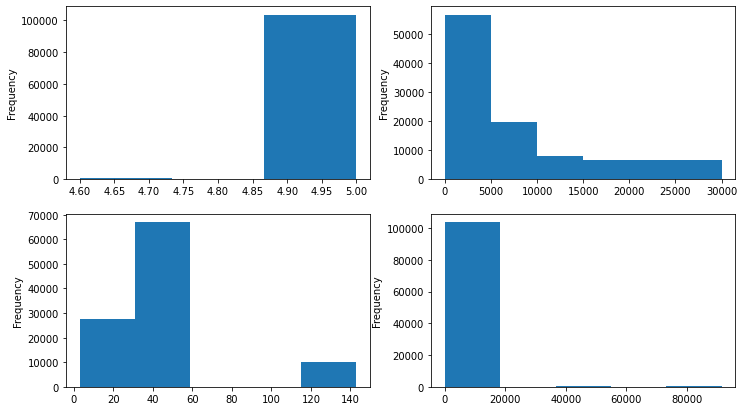

In [404]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
df['Rate'].plot.hist(bins=3, ax=axes[0, 0])
df['Review'].plot.hist(bins=6, ax=axes[0, 1])
df['Price'].plot.hist(bins=5, ax=axes[1, 0])
df['QtyLeft'].plot.hist(bins=5, ax=axes[1, 1])

In [405]:
df.describe()

,Index,Rate,Review,Price,QtyLeft,Sold
count,104620.000000,104620.000000,104620.000000,104620.000000,104620.000000,104620.000000
mean,52309.500000,4.995788,7720.674355,45.471669,1196.745747,11886.488798
std,30201.336919,0.034165,8075.637955,36.049896,6228.274911,13558.083961
min,0.000000,4.600000,1.000000,3.000000,53.000000,5.000000
25%,26154.750000,5.000000,1862.000000,10.000000,483.000000,2585.000000
50%,52309.500000,5.000000,4504.000000,51.000000,490.000000,6284.000000
75%,78464.250000,5.000000,11198.000000,51.000000,983.000000,16133.000000
max,104619.000000,5.000000,29999.000000,143.000000,91434.000000,55902.000000


### Plot of normalized data

In [406]:
normalized_df=df/df.max()
normalized_df['Index'] = df['Index']

<AxesSubplot:xlabel='Index'>

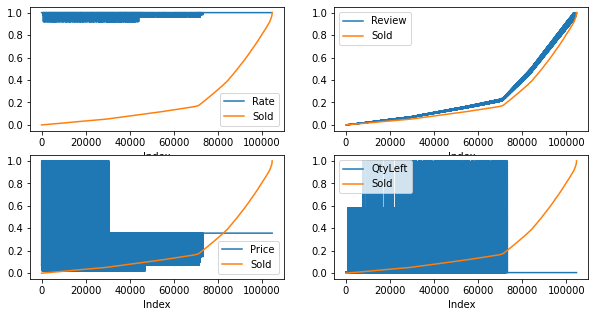

In [407]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

normalized_df.plot(x = "Index", y=['Rate', 'Sold'], ax=axes[0, 0])
normalized_df.plot(x = "Index", y=['Review', 'Sold'], ax=axes[0, 1])
normalized_df.plot(x = "Index", y=['Price', 'Sold'], ax=axes[1, 0])
normalized_df.plot(x = "Index", y=['QtyLeft', 'Sold'], ax=axes[1, 1])

### Correlation analysis

In [408]:
df[['Rate', 'Review', 'Price', 'QtyLeft', 'Sold']].corr(method ='pearson')

,Rate,Review,Price,QtyLeft,Sold
Rate,1.000000,0.083100,0.127708,-0.678658,0.079195
Review,0.083100,1.000000,0.022763,-0.069250,0.996307
Price,0.127708,0.022763,1.000000,-0.062581,0.031255
QtyLeft,-0.678658,-0.069250,-0.062581,1.000000,-0.066934
Sold,0.079195,0.996307,0.031255,-0.066934,1.000000


*From above graph and correlation coefficients, we can see that the review have high absolute coefficient with sold*

# Predict Sold using Review

## 1. Linear Regression

In [409]:
X = df[['Review']]
y = df['Sold']

linear_reg = linear_model.LinearRegression()
linear_reg.fit(X, y)

LinearRegression()

### Calculate MAE and RMSE

In [410]:
yhat = linear_reg.predict(X)
yhat[yhat < 0] = 2
yhat = [int(y_val) for y_val in yhat]

MAE = mean_absolute_error(y, yhat)
RMSE = np.sqrt(mean_squared_error(y, yhat))
print("MAE: {}, RMSE: {}" .format(MAE, RMSE))

MAE: 798.5584591856242, RMSE: 1140.4378982189828


In [411]:
pred_df = df
pred_df['pred_sold'] = yhat
pred_df = pred_df.reset_index(drop=True)
pred_df['Diff(%)'] = abs(pred_df['Sold']-pred_df['pred_sold'])/pred_df['Sold']*100
pred_df.tail(10)

,Index,Rate,Review,Price,QtyLeft,Sold,pred_sold,Diff(%)
104610,104610,5.0,29920.0,51,483,55648.0,49019,11.912378
104611,104611,5.0,29977.0,51,483,55703.0,49114,11.828806
104612,104612,5.0,29914.0,51,483,55710.0,49008,12.030156
104613,104613,5.0,29933.0,51,483,55786.0,49040,12.092640
104614,104614,5.0,29975.0,51,483,55786.0,49111,11.965368
104615,104615,5.0,29964.0,51,483,55791.0,49092,12.007313
104616,104616,5.0,29990.0,51,483,55799.0,49136,11.941074
104617,104617,5.0,29911.0,51,483,55851.0,49003,12.261195
104618,104618,5.0,29930.0,51,483,55869.0,49035,12.232186
104619,104619,5.0,29977.0,51,483,55902.0,49114,12.142678


### Average difference by linear regression model

In [412]:
print("Average Difference: {}" .format(pred_df['Diff(%)'].mean()))

Average Difference: 20.61186197853028


## Plynomial Regression 

In [390]:
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X)
 
poly.fit(X_poly, y)
poly_reg = linear_model.LinearRegression()
poly_reg.fit(X_poly, y)

LinearRegression()

### Calculate MAE and RMSE

In [391]:
yhat = poly_reg.predict(X_poly)
MAE = mean_absolute_error(y, yhat)
RMSE = np.sqrt(mean_squared_error(y, yhat))
print("MAE: {}, RMSE: {}" .format(MAE, RMSE))

MAE: 544.8205344987459, RMSE: 1032.1885322393762


## Theoretical Question:
Can we predict the sold units using review?

In [392]:
pred_df = df
pred_df['pred_sold'] = yhat
pred_df = pred_df.reset_index(drop=True)
pred_df['Diff(%)'] = abs(pred_df['Sold']-pred_df['pred_sold'])/pred_df['Sold']*100
pred_df.tail(10)

,Index,Unnamed: 0,Rate,Review,Price,Left,Sold,pred_sold,Diff(%)
104610,104610,76709,5.0,29297.0,51,483,59639.0,51698.086967,13.314967
104611,104611,95761,5.0,28867.0,51,483,59649.0,50626.867306,15.125371
104612,104612,121496,5.0,29992.0,51,483,60198.0,53458.964493,11.194783
104613,104613,76975,5.0,29784.0,51,483,60223.0,52928.108975,12.113131
104614,104614,150304,5.0,29887.0,51,483,60467.0,53190.569859,12.033721
104615,104615,73998,5.0,29494.0,51,483,60484.0,52193.487738,13.706951
104616,104616,162495,5.0,29530.0,51,483,60813.0,52284.334752,14.024411
104617,104617,21308,5.0,29735.0,51,483,60891.0,52803.533725,13.281875
104618,104618,148568,5.0,29041.0,51,483,61143.0,51058.675353,16.493016
104619,104619,135919,5.0,29358.0,51,483,61419.0,51851.172324,15.577961


### Average difference by polynomial regression model

In [395]:
print("Average Difference: {}" .format(pred_df['Diff(%)'].mean()))

Average Difference: 4.881412035514314


*From above results, the mean absolute error is 544.82 and the root mean squared error is 1032.188. And the average percent of difference between sold and predicted sold is 4.88%.*